When we are calculating equilibrium concentrations, we can usually use an ICE table to create a polynomial equation and then solve the resulting equation. However, this method won't always work, particularly when there are multiple reactions occuring that affect the equilibrium concentrations. In those cases we will need to solve multiple equations, which are typically non-linear, simultaneously. In this notebook we will see how to do this, using the solubility of silver chloride as an example. First things, import dependencies:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt

Before we get to the more complicated calculations, let's calculate the solubility of AgCl in pure water. The overall solubility reaction is:  
$$\textrm{AgCl} \rightarrow \textrm{Ag}^{+}_{(aq)} + \textrm{Cl}^{-}_{(aq)} \qquad \textrm{K}_{sp} = 1.82 \textrm{x} 10^{-10}$$  
Probably the easiest way to do this is to write a function that can solve the quadratic equation (which I will call quad_solve), and then use it to solve for [Ag$^{+}$]. For this,  solving a quadratic equation is a little bit of overkill, but will be necessary in the next step. As a reminder, a function (whether a math function or computer function) is something that takes some inputs, manipulates them in some way, and then gives back the manipulated results. To write a function in python, we first define it (using the "def" keyword), then all the lines that are part of the function are inset 1 tab, then we use the "return" key word to tell the function what to give back. Note that the quadratic function solver I've written, below, returns both roots, and so we'll need to be careful when we choose which root we want.

From the ICE table we know that [Ag$^{+}$][Cl$^{-}$] = 1.82 x 10$^{-10}$, and [Ag$^{+}$] = [Cl$^{-}$], so [Ag$^{+}$]$^{2}$ = 1.82 x 10$^{-10}$. This means that, for the quadratic equation, a = 1, b = 0, and c = -1.82 x 10$^{-10}$ (you may want to double check this, so you understand where these numbers come from).

In [2]:
def quad_solve(a, b, c):
    discrim = np.sqrt(b**2 - 4 * a * c)
    sol1 = (-b + discrim)/(2 * a)
    sol2 = (-b - discrim)/(2 * a)
    return [sol1,sol2]

solutions = quad_solve(1,0,-1.82E-10)
corrsol="{:.2E}".format(solutions[0])
print("The solubility of AgCl in pure water is",corrsol)

The solubility of AgCl in pure water is 1.35E-05


Now let's take the common ion effect into account and calculate the solubility of AgCl in 0.1M KCl. In this case, the ICE table gives us a = 1, b = 0.1, and c = -1.82 x 10$^{-10}$. Hopefully you can now see why the quadratic solver function is useful. Again, you should make an ICE table to double check my numbers. You should also check both roots to make sure that the one I've chosen, below, is correct.

In [3]:
solutions = quad_solve(1,0.1,-1.82E-10)
corrsol="{:.2E}".format(solutions[0])
print("The solubililty of AgCl in 0.1M KCl is",corrsol)

The solubililty of AgCl in 0.1M KCl is 1.82E-09


Now we can graph the solubility of AgCl in solutions of KCl as a function of KCl concentration, from 0 to 0.1 M. The easiest way to graph things in python is to create a two-dimensional list of points representing x and y values, similar to what we did in the previous notebook on calibration curves. So I will use the linspace() function from the numpy package to create a set of 100 points evenly distributed between 0.00001 and 0.1 to use as my different KCl concentrations (which will be the x-points), and then use the quadsolve function I wrote above with those x-points to find the solubility of AgCl (which will be the y-points). I can then graph those x,y points with the plot() function from the matlibpyplot package.

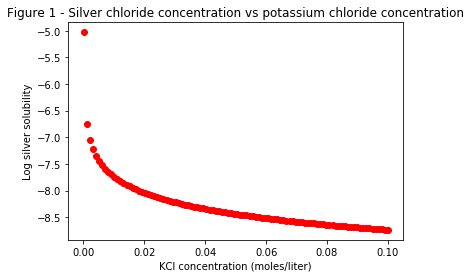

In [4]:
datapts = 100

xrange = np.linspace(.00001,0.1,num=datapts)
yrange = quad_solve(1,xrange,-1.82E-10)

plt.plot(xrange, np.log10(yrange[0]), 'ro')
plt.title("Figure 1 - Silver chloride concentration vs potassium chloride concentration")
plt.xlabel('KCl concentration (moles/liter)')
plt.ylabel('Log silver solubility')
plt.show()

As you can see, the solubility at [KCl] = 0M and at 0.1M are what we calculated above, and the behavior is what we expect for a common ion effect. Unfortunately, this doesn't help us if we need to solve multiple equations simultaneously. So, how do we do that? I'm going to use the fsolve() function, from the scipy package, rather than the quadratic equation I wrote to find [Ag$^{+}$]. This is more work than what I did above, but will pay off in the long-run.

The fsolve() function uses an iterative process to find the solution to a set of equations, and works on non-linear equations. For this problem, we have three unknowns ([Ag$^{+}$], [Cl$^{-}$], and [K$^{+}$]), and so we will need to come up with three equations. We will also need to provide fsolve() with a guess for it to start with, and I'm going to use the initial conditions as the guess. To get this working I'm going to start with just one KCl concentration, 0.1 M. Therefore, my initial state is: [Ag$^{+}$] = 0, [Cl$^{-}$] = [K$^{+}$] = 0.1 M. In addition, because fsolve() requires an input that is a function, I need to write a function, which I'll call AgCl_sol, that returns three equations.

In [5]:
initAg = 0
initCl = initK = 0.1

initparams = (initAg, initCl, initK)

def AgCl_sol(concentrations):
    (Ag_conc, Cl_conc, K_conc) = concentrations
    
    firstEq = Ag_conc * Cl_conc - 1.82E-10
    secondEq = Ag_conc + K_conc - Cl_conc
    thirdEq = K_conc - K_conc
    
    return[firstEq, secondEq, thirdEq]

solution = opt.fsolve(AgCl_sol,initparams)

solubility = "{:.2E}".format(solution[0])

print("At a KCl concentration of", initK, "AgCl solubility is", solubility)

At a KCl concentration of 0.1 AgCl solubility is 1.82E-09


Take a look at the AgCl\_sol() function that I wrote, above. Where does the first equation come from?

Where does the second equation come from?

What is the third equation telling the computer?

You'll note that for all three I manipulated them so that I have an equation that is equal to zero. This is a requirement of the fsolve() function.


Now I can use the function I created above and the fsolve() function to calculate and graph the solubility of AgCl in KCl, with a KCl concentration ranging from near zero to 0.1 M. I can't start at zero because I'll get weird issues with the function I wrote. Because I'm working over a large range of values, I decided to use x points that are evenly distributed along a log axis, rather than a linear axis, so I am using the logspace() function from the numpy package to create my x range. Otherwise, it's fairly similar to what I did above.

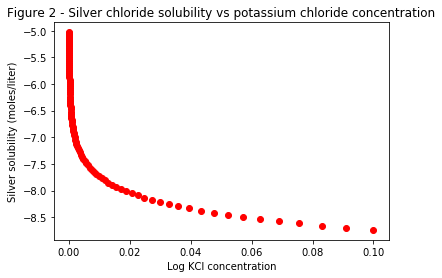

In [6]:
logxrange = np.logspace(-5,-1,num=datapts)

#Below is my starting points, with Ag+ = 0, K+ and Cl- = x-range
guess_array = tuple(zip(np.zeros(datapts),logxrange,logxrange)) 

out_array = []
silver_conc = []
chloride_conc = []
potassium_conc = []

for num in range(0,datapts):
    out_array.append(list(opt.fsolve(AgCl_sol,guess_array[num])))
    silver_conc.append(out_array[num][0])
    chloride_conc.append(out_array[num][1])
    potassium_conc.append(out_array[num][2])

plt.plot(potassium_conc,np.log10(silver_conc),'ro')
plt.title("Figure 2 - Silver chloride solubility vs potassium chloride concentration")
plt.xlabel('Log KCl concentration')
plt.ylabel('Silver solubility (moles/liter)')
plt.show()

That was a lot more work, and more challenging than writing a quadratic formula function, for the same answer. So, why did I go through all that work to do it with fsolve? Well, now we can use fsolve for multiple *non-linear* equations that don't reduce to a quadratic. For example, let's add in an additional reaction: 

$$\textrm{Ag}^{+}_{(aq)} + \textrm{2 Cl}^{-}_{(aq)} \rightarrow \textrm{AgCl}^{-}_{2(aq)} \qquad \textrm{K}_{F} = 1.78 \textrm{x} 10^{5}$$

Now we can  use the fsolve() function to find the solubility of AgCl taking this additional equilibrium into account. First, let's just find the solubility at a single KCl concentration of 0.1M. To do this I will need to write a new function, which I call AgCl\_sol2(), that returns four equations since there are now four unknowns ([$\textrm{Ag}^{+}_{(aq)}$], [$\textrm{Cl}^{-}_{(aq)}$], [$\textrm{AgCl}^{-}_{2(aq)}$], [$\textrm{K}^{+}_{(aq)}$]). Note that the total solubility of AgCl will be [$\textrm{Ag}^{+}_{(aq)}$] + [$\textrm{AgCl}^{-}_{2(aq)}$].

In [7]:
initAg = initAgCl2 = 0
initCl = initK = 0.1

initparams = (initAg, initAgCl2, initCl, initK)

def AgCl_sol2(concentrations):
    (Ag_conc2, AgCl2_conc2, Cl_conc2, K_conc2) = concentrations
    
    firstEq = Ag_conc2 * Cl_conc2 - 1.82E-10
    secondEq = AgCl2_conc2 - Ag_conc2 * Cl_conc2 ** 2 * 1.78E5
    thirdEq = Ag_conc2 + K_conc2 - Cl_conc2 - AgCl2_conc2
    fourthEq = K_conc2 - K_conc2
    
    return[firstEq, secondEq, thirdEq, fourthEq]

solution = opt.fsolve(AgCl_sol2,initparams)

solubility = "{:.2E}".format(solution[0] + solution[1])

print("At a KCl concentration of", initK, "AgCl solubility is", solubility)

At a KCl concentration of 0.1 AgCl solubility is 3.24E-06


Now that it works at a single KCl concentration, we can combine what we've done so far and graph the silver solubility over a range of KCl concentrations!

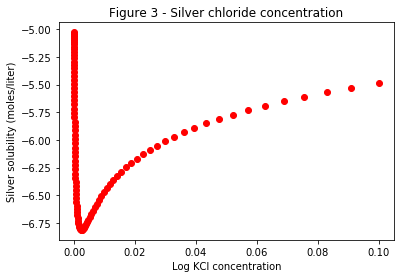

In [8]:
#Below is my starting points, with Ag+ = AgCl2- = 0, K+ and Cl- = x-range
guess_array2 = tuple(zip(np.zeros(datapts),np.zeros(datapts),logxrange,logxrange))

out_array2 = []
silver_conc2 = []
silverchloride_conc2 = []
chloride_conc2 = []
potassium_conc2 = []

for num in range(0,datapts):
    out_array2.append(list(opt.fsolve(AgCl_sol2,guess_array2[num])))
    silver_conc2.append(out_array2[num][0])
    silverchloride_conc2.append(out_array2[num][1])    
    chloride_conc2.append(out_array2[num][2])
    potassium_conc2.append(out_array2[num][3])

total_solubility = np.add(silver_conc2, silverchloride_conc2)

plt.plot(potassium_conc2,np.log10(total_solubility),'ro')
plt.title("Figure 3 - Silver chloride concentration")
plt.xlabel('Log KCl concentration')
plt.ylabel('Silver solubility (moles/liter)')
plt.show()

Now we see very different behavior for the solubility of silver chloride than what we predicted above, behavior that is actually consistent with what is observed experimentally.

Now let's add in an additional equilibrium:

$$\textrm{AgCl}^{-}_{2(aq)} + \textrm{Cl}^{-}_{(aq)} \rightarrow \textrm{AgCl}^{2-}_{3(aq)} \qquad \textrm{K}_{F} = 2.34$$

Now, let's find the solubility at a single KCl concentration of 0.1 M accounting for all three reactions. In the box below, use the fsolve() function to find the solubility of AgCl taking this third equilibrium into account, similar to the work above.  To do this you will need to write a new function, let's call it AgCl\_sol3(), that returns five equations, since there are now five unknowns ([$\textrm{Ag}^{+}_{(aq)}$], [$\textrm{Cl}^{-}_{(aq)}$], [$\textrm{AgCl}^{-}_{2(aq)}$], [$\textrm{AgCl}^{2-}_{3(aq)}$], [$\textrm{K}^{+}_{(aq)}$]). You'll also need to be a little careful, because the AgCl solubility will now be [$\textrm{Ag}^{+}_{(aq)}$] + [$\textrm{AgCl}^{-}_{2(aq)}$] + [$\textrm{AgCl}^{2-}_{3(aq)}$], but the np.add() function can only take two inputs.

Now that you can find the solubility of AgCl at a single KCl concentration, graph the silver solubility for KCl concentrations from 10$^{-5}$ M to 10$^{-1}$ M, similar to above.

Using the graph you have just produced, *estimate* the KCl concentration that results in the lowest silver solubility:
